In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# import os
# import torch, torchvision
# import torchvision.transforms as transforms
# from torch import nn, cuda, backends, FloatTensor, LongTensor, optim
# import torch.nn.functional as F
# from torch.autograd import Variable
# from torch.utils.data import Dataset, TensorDataset
# from torch.nn.init import kaiming_uniform, kaiming_normal

In [10]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.cuda.set_device(0)
from torchvision.models import vgg16_bn
torch.backends.cudnn.benchmark=True

In [11]:
PATH = Path('../images/')

In [12]:
! ls {PATH}

content2.jpg  content.jpg  style2.jpg  style.jpg


Pretrained models from `torch.vision`

In [13]:
m_vgg = to_gpu(vgg16(True).eval()) # set to evaluation mode

In [14]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

In [15]:
set_trainable(m_vgg, False) # not trainable

In [16]:
def opencv2_image(fn):
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    im = cv2.imread(str(fn), flags).astype(np.float32)/255
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

#### Content image

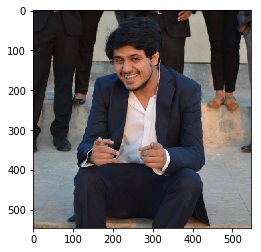

In [125]:
img_fn = PATH/'negi.jpg'
img = opencv2_image(img_fn)

# plt.figure(figsize=(12,6))
plt.imshow(img);

In [126]:
img.shape

(546, 546, 3)

In [127]:
sz = 288 # no specific reason

In [128]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)  ## this part is from fastai transforms. should have my own soemnow
img_tfm = val_tfms(img) # as this is not being trained. forward pass
img_tfm.shape

(3, 288, 288)

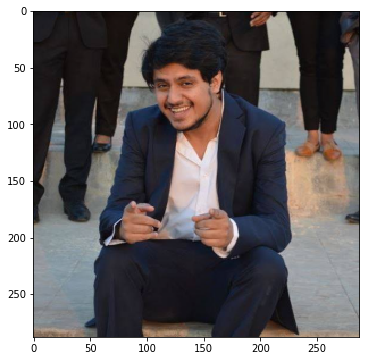

In [129]:
# transformed image

plt.figure(figsize=(12,6))
plt.imshow(val_tfms.denorm(np.rollaxis(img_tfm,0,3)));  # axis got changed after transformation

#### Random initialized image

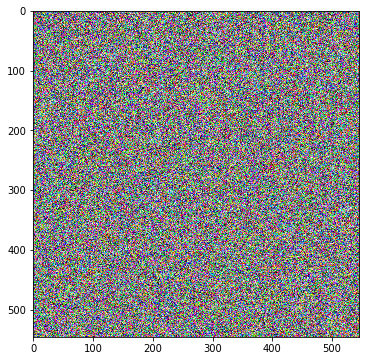

In [130]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32) # same shape as input image
plt.figure(figsize=(12,6))
plt.imshow(opt_img);

Median filters 

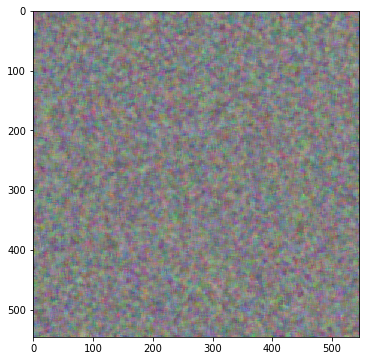

In [131]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1]) # smoothening of random image as actually images are smooth
plt.figure(figsize=(12,6))
plt.imshow(opt_img);

In [132]:
opt_img.shape

(546, 546, 3)

In [133]:
# applying transforms on initialized img

opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [134]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [135]:
m_vgg[-1]

ReLU(inplace)

In [136]:
img_tfm[None].shape

(1, 3, 288, 288)

In [137]:
targ_t = m_vgg(VV(img_tfm[None])) # pass it into vgg network. forward pass
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [138]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)  # works good in this case as loss fn is not parameter but pixel

In [139]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [285]:
def step(loss_fn):
    global n_iter # get global n_ter 
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [141]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: n_iter, loss: 0.9151296019554138
Iteration: n_iter, loss: 0.39182761311531067
Iteration: n_iter, loss: 0.26164543628692627
Iteration: n_iter, loss: 0.20177072286605835
Iteration: n_iter, loss: 0.16901463270187378
Iteration: n_iter, loss: 0.14899329841136932
Iteration: n_iter, loss: 0.13558146357536316
Iteration: n_iter, loss: 0.12589944899082184
Iteration: n_iter, loss: 0.11812564730644226
Iteration: n_iter, loss: 0.11214273422956467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


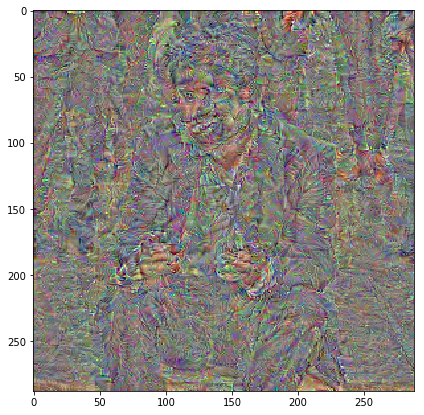

In [142]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

### Use of forward hook
In above case, we randomly picked activation of 36th layer. But we can use output of multiple layers. We need layers just before max pool. 

In [143]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [144]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [145]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [220]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [221]:
# get random initialized image

def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [222]:
opt_img_v, optimizer = get_opt()

In [223]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [224]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*100000

In [225]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: n_iter, loss: 23.013639450073242
Iteration: n_iter, loss: 10.13689136505127
Iteration: n_iter, loss: 6.608846187591553
Iteration: n_iter, loss: 4.9602837562561035
Iteration: n_iter, loss: 4.026381969451904
Iteration: n_iter, loss: 3.420964002609253
Iteration: n_iter, loss: 3.008857488632202
Iteration: n_iter, loss: 2.693413257598877
Iteration: n_iter, loss: 2.4546496868133545
Iteration: n_iter, loss: 2.267205238342285


In [226]:
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [227]:
np.rollaxis(to_np(opt_img_v.data),1,4).shape

(1, 288, 288, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


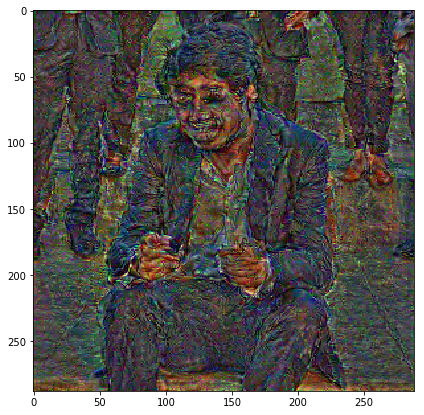

In [228]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [229]:
sf.close()


### Style match

In [50]:
style_fn = PATH/'content4.jpg'

In [51]:
style_img = opencv2_image(style_fn)
style_img.shape, img.shape

((468, 749, 3), (468, 749, 3))

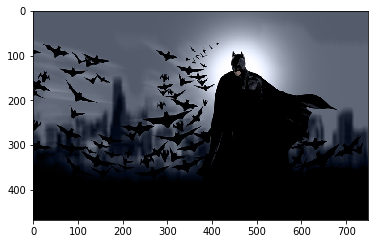

In [52]:
plt.imshow(style_img)

In [53]:
def scale_match(src, targ):
    """
    match dimensions with content image
    """
    
    h,w,_ = src.shape  # content image
    sh,sw,_ = targ.shape  # style image
    rat = max(h/sh,w/sw); rat 
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [54]:
style = scale_match(img, style_img)

In [55]:
style.shape

(468, 749, 3)

((468, 749, 3), (468, 749, 3))

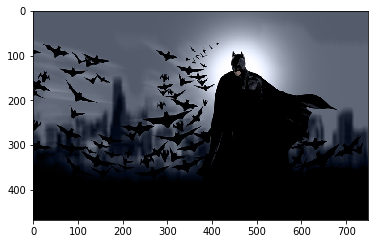

In [56]:
plt.imshow(style)
style.shape, img.shape

In [239]:
opt_img_v, optimizer = get_opt()

In [240]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [241]:
# original content image

m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [242]:
# transform (augment) style image

style_tfm = val_tfms(style_img) 

In [243]:
# activations from multiple layers for style image

m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

Our aim is to make `gram_matrix` of noise image as close as the style image. This makes noisy image copy style of syle image

In [244]:
targ_styles[0].view(1*64, -1).shape

torch.Size([64, 82944])

Need to multiply `64` vectos of `82944` length 

In [245]:
g = targ_styles[0]

In [246]:
64*82944

5308416

In [247]:
g.numel() #number of elements

5308416

In [248]:
def gram(input):
        b,c,h,w = input.size()  # batch sz, channels, height, width 
        x = input.view(b*c, -1) 
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [249]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [250]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 10875.5068359375
Iteration: n_iter, loss: 6275.80908203125
Iteration: n_iter, loss: 4238.17529296875
Iteration: n_iter, loss: 2713.9140625
Iteration: n_iter, loss: 1757.7601318359375
Iteration: n_iter, loss: 1176.58935546875
Iteration: n_iter, loss: 845.4829711914062
Iteration: n_iter, loss: 635.486083984375
Iteration: n_iter, loss: 494.53125
Iteration: n_iter, loss: 401.42376708984375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


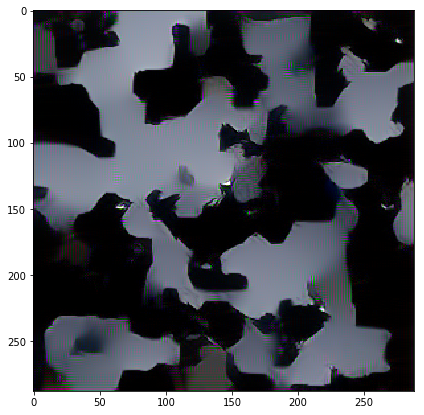

In [251]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [252]:
for sf in sfs: sf.close()

### Style transfer

In [299]:
opt_img_v, optimizer = get_opt()

In [300]:
block_ends

[5, 12, 22, 32, 42]

In [301]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [302]:
sfs

In [303]:
# original content image

m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [304]:
# activations from multiple layers for style image

m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [307]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s)*wt for o,s,wt in zip(outs, targ_styles, [0.025,0.275,5.,0.2])]  # [0.025,0.275,5.,0.2]
#     print(losses)
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1e5
#     print(cnt_loss)
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [308]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 2841.71630859375
Iteration: 200, loss: 2248.140625
Iteration: 300, loss: 1803.5380859375
Iteration: 400, loss: 1475.9283447265625
Iteration: 500, loss: 1198.767578125
Iteration: 600, loss: 1011.2630615234375
Iteration: 700, loss: 906.9837036132812
Iteration: 800, loss: 835.7401733398438
Iteration: 900, loss: 781.46240234375
Iteration: 1000, loss: 740.3544921875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


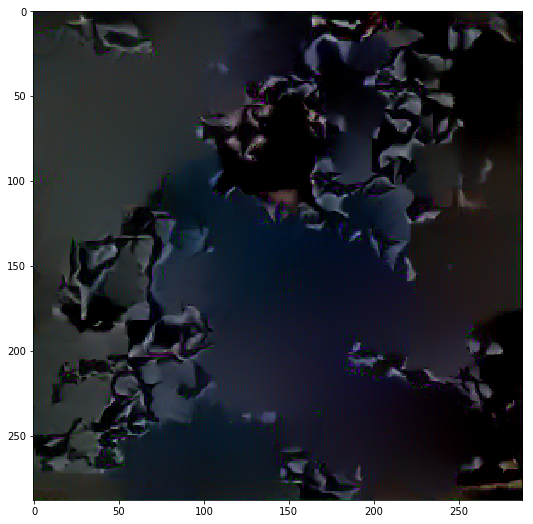

In [309]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x)
# plt.axis('off');

In [310]:
for sf in sfs: sf.close()

### Let's see different layers of both style and content

### Style blocks

In [58]:
opt_img_v, optimizer = get_opt()

In [59]:
block_ends

[5, 12, 22, 32, 42]

Layers used to check recreations: `1, 1-2, 1-2-3, 1-2-3-4, 1-2-3-4-5`

#### 1

In [68]:
# activations from multiple layers for style image

sfs = SaveFeatures(children(m_vgg)[block_ends[0]])
m_vgg(VV(style_tfm[None]))
targ_styles = V(sfs.features.clone())
targ_styles.shape

torch.Size([1, 64, 288, 288])

In [74]:
def style_loss_one(x):
    m_vgg(x)
    outs = V(sfs.features)
    losses = gram_mse_loss(outs, targ_styles) 
    return losses

In [77]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss_one))

Iteration: n_iter, loss: 2670.3876953125
Iteration: n_iter, loss: 396.8776550292969
Iteration: n_iter, loss: 85.67351531982422
Iteration: n_iter, loss: 12.144351959228516
Iteration: n_iter, loss: 3.0516741275787354
Iteration: n_iter, loss: 1.1008716821670532
Iteration: n_iter, loss: 0.5185732245445251
Iteration: n_iter, loss: 0.28455817699432373
Iteration: n_iter, loss: 0.1804007589817047
Iteration: n_iter, loss: 0.11834892630577087


In [79]:
x1 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

#### 1-2

In [99]:
opt_img_v, optimizer = get_opt()

In [100]:
block_ends[:2]

[5, 12]

In [101]:
# original content image
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends[:2]]

m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]), torch.Size([1, 128, 144, 144])]

In [102]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 7651.8359375
Iteration: n_iter, loss: 3452.8271484375
Iteration: n_iter, loss: 1631.461181640625
Iteration: n_iter, loss: 885.3443603515625
Iteration: n_iter, loss: 546.9853515625
Iteration: n_iter, loss: 382.4227294921875
Iteration: n_iter, loss: 281.84271240234375
Iteration: n_iter, loss: 217.79322814941406
Iteration: n_iter, loss: 171.83155822753906
Iteration: n_iter, loss: 138.44546508789062


In [103]:
x2 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

#### 1-2-3

In [104]:
opt_img_v, optimizer = get_opt()

In [105]:
# original content image
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends[:3]]

m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72])]

In [106]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 7391.51611328125
Iteration: n_iter, loss: 3246.5673828125
Iteration: n_iter, loss: 1499.5272216796875
Iteration: n_iter, loss: 851.3440551757812
Iteration: n_iter, loss: 582.3472290039062
Iteration: n_iter, loss: 423.5267333984375
Iteration: n_iter, loss: 326.4472961425781
Iteration: n_iter, loss: 273.0113830566406
Iteration: n_iter, loss: 237.37576293945312
Iteration: n_iter, loss: 211.55723571777344


In [108]:
x3 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

#### 1-2-3-4

In [113]:
opt_img_v, optimizer = get_opt()

# original content image
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends[:4]]

m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]

n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

x4 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

Iteration: n_iter, loss: 7358.83935546875
Iteration: n_iter, loss: 3526.944580078125
Iteration: n_iter, loss: 1881.963623046875
Iteration: n_iter, loss: 1081.9012451171875
Iteration: n_iter, loss: 713.9521484375
Iteration: n_iter, loss: 521.2159423828125
Iteration: n_iter, loss: 399.30853271484375
Iteration: n_iter, loss: 309.9601745605469
Iteration: n_iter, loss: 252.30130004882812
Iteration: n_iter, loss: 212.75299072265625


#### 1-2-3-4-5

In [115]:
opt_img_v, optimizer = get_opt()

# original content image
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]

n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

x5 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

Iteration: n_iter, loss: 10970.9716796875
Iteration: n_iter, loss: 6292.45849609375
Iteration: n_iter, loss: 4465.52392578125
Iteration: n_iter, loss: 3251.612060546875
Iteration: n_iter, loss: 2365.639892578125
Iteration: n_iter, loss: 1779.64306640625
Iteration: n_iter, loss: 1389.705810546875
Iteration: n_iter, loss: 1123.1629638671875
Iteration: n_iter, loss: 929.41943359375
Iteration: n_iter, loss: 772.5211181640625


#### Plots 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


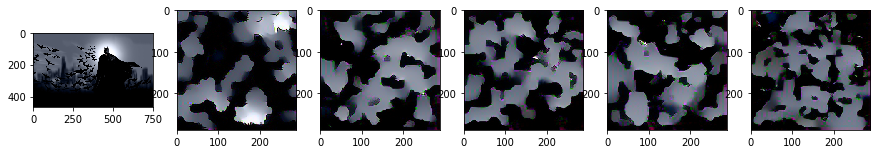

In [124]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize = (15,7))

ax1.imshow(style_img)
ax2.imshow(x1)
ax3.imshow(x2)
ax4.imshow(x3)
ax5.imshow(x4)
ax6.imshow(x5)

The more layers we add, richer background features it captures

### Content blocks

In [204]:
def actn_loss3(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*100000

#### C1

In [167]:
opt_img_v, optimizer = get_opt()
sf = SaveFeatures(children(m_vgg)[block_ends[0]])

In [168]:
# original content image
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())

In [169]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss3))

Iteration: n_iter, loss: 0.01845257170498371
Iteration: n_iter, loss: 5.483876884682104e-05
Iteration: n_iter, loss: 6.408327863027807e-06
Iteration: n_iter, loss: 1.5637878050256404e-06
Iteration: n_iter, loss: 4.6067418679740513e-07
Iteration: n_iter, loss: 1.7382056682890834e-07
Iteration: n_iter, loss: 8.783116101085398e-08
Iteration: n_iter, loss: 5.757544130347014e-08
Iteration: n_iter, loss: 4.6838675160643106e-08
Iteration: n_iter, loss: 4.544464715650065e-08


In [170]:
xc1 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

#### C2

In [202]:
opt_img_v, optimizer = get_opt()
sf = SaveFeatures(children(m_vgg)[block_ends[1]])

In [203]:
# original content image
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())

In [205]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss3))

Iteration: n_iter, loss: 105.98896789550781
Iteration: n_iter, loss: 31.681196212768555
Iteration: n_iter, loss: 14.733980178833008
Iteration: n_iter, loss: 8.671920776367188
Iteration: n_iter, loss: 5.655834674835205
Iteration: n_iter, loss: 4.544142723083496
Iteration: n_iter, loss: 4.015957355499268
Iteration: n_iter, loss: 3.693615198135376
Iteration: n_iter, loss: 3.4954652786254883
Iteration: n_iter, loss: 3.379074811935425


In [206]:
xc2 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

#### C3

In [184]:
opt_img_v, optimizer = get_opt()
sf = SaveFeatures(children(m_vgg)[block_ends[2]])

In [185]:
# original content image
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())

In [187]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss3))

Iteration: n_iter, loss: 107.52100372314453
Iteration: n_iter, loss: 64.6032943725586
Iteration: n_iter, loss: 47.00164794921875
Iteration: n_iter, loss: 36.70768737792969
Iteration: n_iter, loss: 29.913616180419922
Iteration: n_iter, loss: 25.18185043334961
Iteration: n_iter, loss: 21.652809143066406
Iteration: n_iter, loss: 18.810943603515625
Iteration: n_iter, loss: 16.53890037536621
Iteration: n_iter, loss: 14.632087707519531


In [188]:
xc3 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

#### C4

In [189]:
opt_img_v, optimizer = get_opt()
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [190]:
# original content image
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())

In [191]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss3))

Iteration: n_iter, loss: 23.00412940979004
Iteration: n_iter, loss: 10.20561695098877
Iteration: n_iter, loss: 6.5265913009643555
Iteration: n_iter, loss: 4.880352020263672
Iteration: n_iter, loss: 3.9646682739257812
Iteration: n_iter, loss: 3.3611326217651367
Iteration: n_iter, loss: 2.944981336593628
Iteration: n_iter, loss: 2.634681463241577
Iteration: n_iter, loss: 2.393872022628784
Iteration: n_iter, loss: 2.206409454345703


In [192]:
xc4 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

#### C5

In [193]:
opt_img_v, optimizer = get_opt()
sf = SaveFeatures(children(m_vgg)[block_ends[4]])

In [194]:
# original content image
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())

In [195]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss3))

Iteration: n_iter, loss: 470.53704833984375
Iteration: n_iter, loss: 180.48692321777344
Iteration: n_iter, loss: 105.07618713378906
Iteration: n_iter, loss: 78.50385284423828
Iteration: n_iter, loss: 65.45003509521484
Iteration: n_iter, loss: 56.424957275390625
Iteration: n_iter, loss: 49.434356689453125
Iteration: n_iter, loss: 44.805965423583984
Iteration: n_iter, loss: 41.55037307739258
Iteration: n_iter, loss: 39.209747314453125


In [196]:
xc5 = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]

#### Plots 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


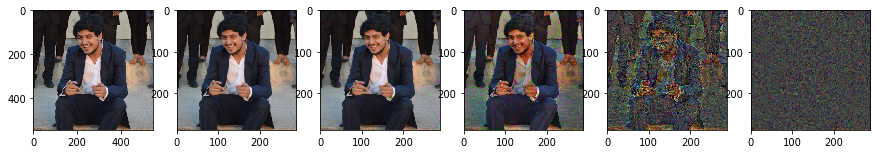

In [207]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize = (15,7))

ax1.imshow(img)
ax2.imshow(xc1)
ax3.imshow(xc2)
ax4.imshow(xc3)
ax5.imshow(xc4)
ax6.imshow(xc5)

Initial layers are able to generate whole face. But last layers only generate semantic parts. 

### End